# Construct constrained realization

In this section, we show an example to use ``gsCR`` to constrain a random realization of linear density field.
In this example, we use ``fastpm`` package to generate random realization of density field (at z=0).

In [1]:
%pylab inline

from pmesh.pm import ParticleMesh
from fastpm.core import leapfrog, Solver, autostages

from gaussianCR.construct import *
from gaussianCR.cosmo import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
# some style of the notebook
plt.rc('xtick', labelsize=15)    
plt.rc('ytick', labelsize=15) 
np.set_printoptions(precision=3,linewidth=150,suppress=True)

---


**initialize cosmology**

In [3]:
import nbodykit.cosmology as nbcosmos 
wmap9 = Cosmos(FLRW=True,obj=nbcosmos.WMAP9)

---


**initialize gsCR object**

Here we use wmap9 cosmology, set the box size to be 20 Mpc/$h$, Gaussian kernel length $R_G = 0.9$ Mpc/$h$, density field in shape of (128,128,128)

In [4]:
Lbox = 20 # Mpc/h
Ng = 128  # number of grid to represent the dx_field
RG = 0.9  # Mpc/h

In [5]:
fg = gsCR(wmap9,Lbox,Ng,RG)

---


**generate a random linear density field**


Here we use ``fastpm`` and ``pmesh`` to generate a random realization of the linear density field with WMAP9 cosmology, with a random seed.
Users can also import their own density field with the matched boxsize, shape and normalization.
Note that our dx_field is the density contrast field $\delta_x = \delta/\bar{\delta} - 1$ at $z=0$.

In [6]:
pm = ParticleMesh(BoxSize=Lbox, Nmesh=[Ng,Ng,Ng])
Q = pm.generate_uniform_particle_grid(shift=0)
solver = Solver(pm,nbcosmos.WMAP9, B=1)

wn = solver.whitenoise(seed = 189953)
dlin = solver.linear(wn, lambda k: wmap9.Pk_lin(k))

# extract the linear field as a numpy array
dx_field = dlin.c2r().value 

Let's quickly visualize the random realization by projecting it on xy plane:

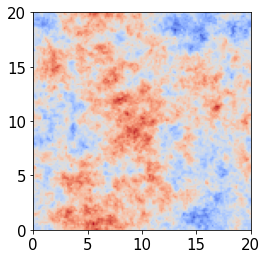

In [7]:
den_field = np.transpose(np.sum(dx_field,axis=-1))
plt.imshow(den_field,cmap='coolwarm',origin='lower',extent=(0,Lbox,0,Lbox))

---


**decide the position to impose the constraint**


We can choose whereever we like to impose our constraints. One choice is to find the original peak of the linear density field. ``gsCR.find_xpk`` method would convolve dx_field with Gaussian kernel with scale $R_G$ and find the peak of the smoothed dx_field.

In [8]:
xpk = fg.find_xpk(dx_field)
print (xpk)

fg.xpk = xpk

[10.156  8.594 13.438]


---


**Obtain the original {$c_i$} of the unconstrained density field**

We use ``gsCR.read_out_c18`` to obtain the original values {$c_i$} of the dx_field, ``read_out_c18`` also return a structured array that convert {$c_i$} to our famaliar peak parameters

In [9]:
c_original,peak_data = fg.read_out_c18(dx_field,rpos=xpk)

peak_data is a structured array that convert {$c_i$} into the peak parameters:

In [10]:
def print_info(peak_data):    
    print ("Significance = %.2f"%peak_data['nu'])
    print ("dfG/dx, dfG/dy, dfG/dz = ",peak_data['f1'])
    print ("xd = %.2f"%peak_data['xd'],"a12sq = %.2f"%peak_data['a12sq'],"a13sq = %.2f"%peak_data['a13sq'])
    print ("Euler1: a1, b1, p1 = ",peak_data['Euler1'])
    print ("vx,vy,vz (peak velocity in km/s) :",peak_data['v_peculiar'])
    print ("epsilon = %.2f"%peak_data['epsilon'],"omega = %.2f"%peak_data['omega'])
    print ("Euler2: a2, b2, p2 = ",peak_data['Euler2'])    

features of the original density peak at xpk

In [11]:
print_info(peak_data) 

Significance = 3.18
dfG/dx, dfG/dy, dfG/dz =  [[-0.023 -0.017 -0.009]]
xd = 1.60 a12sq = 4.08 a13sq = 17.43
Euler1: a1, b1, p1 =  [[1.477 1.743 2.308]]
vx,vy,vz (peak velocity in km/s) : [[-45.356 -32.195  44.299]]
epsilon = 35.76 omega = 5.71
Euler2: a2, b2, p2 =  [[1.382 1.16  1.585]]


---


**Build the corresponding Ensemble Mean Field**

In this example, let's impose the full 18 constraints to xpk, building a density peak at xpk with peak height $\nu = 5 \sigma_0(R_G)$, compactness $x_d = 4 \sigma_2(R_G)$, ellipticity $(a_1/a_2)^2 = 1.4$,$(a_1/a_3)^2 = 2.0$, peculiar velocity $v_{G,x} = v_{G,y} = v_{G,z} = 0$ km/s, tidal field mangitude $\epsilon = 58$ km/s/Mpc, $\omega = 1.5 \pi$. Euler1 is set so that we orientate the longest axis of mass ellipsoid in $x$ direction, shortest axis in $z$ direction. Euler2 is set to make the density peak elongated in $x$ direction and compressed in $z$ direction.

In [12]:
fg.CONS = ['full']
fg.build_Xij_inv_matrix()

In [13]:
c_target = fg.set_c_values(nu=5,xd=4,a12sq=1.4,a13sq=2.0,a1=0,b1=0,p1=0,
                           vx=0,vy=0,vz=0,epsilon=58,omega=4.71,a2=np.pi,b2=0.5*np.pi,p2=0.5*np.pi)

Constrain peak parameters: 
f0:  nu = 5.0 $\sigma_0$
f1:  {f1,x = f1,y = f1,z = 0
f2:  xd = 4.0 $\sigma_2$, a12sq = 1.4, a13sq = 2.0,a1=0.00, b1=0.00, p1=0.00
vx = 0.0 km/s
vy = 0.0 km/s
vz = 0.0 km/s
TG:  epsilon = 58.0 km/s/Mpc, omega = 4.71, a2=3.14, b2=1.57, p2=1.57


The constrained field is constructed by


$f(\mathbf x) = \tilde{f} (\mathbf x)  + \xi_i(\mathbf x) \xi^{-1}_{ij} (c_j - \tilde{c}_j)$

In [14]:
dc = c_target - c_original
dx_ensemble = fg.Ensemble_field(dc)
dx_constraint = dx_field + dx_ensemble

Here we obtain the dx_constraint as the constrained density field

---




**Verify the constrained field**

Here we check that dx_constrained indeed statisfies all the features we want, with ``gsCR.read_out_c18`` method

In [15]:
c_result, peak_result = fg.read_out_c18(dx_constraint,xpk)

In [16]:
print_info(peak_result) 

Significance = 5.00
dfG/dx, dfG/dy, dfG/dz =  [[-0. -0. -0.]]
xd = 4.00 a12sq = 1.40 a13sq = 2.00
Euler1: a1, b1, p1 =  [[0.    3.142 0.   ]]
vx,vy,vz (peak velocity in km/s) : [[ 0. -0. -0.]]
epsilon = 57.97 omega = 4.71
Euler2: a2, b2, p2 =  [[3.142 1.571 1.571]]


---


**Visualize the constrained density field**

Here we plot the unconstrained, constrained density fields and the ensemble mean field, projected on xy plane with slab width of 5 Mpc/h to better visualize the surrounding of the peak.

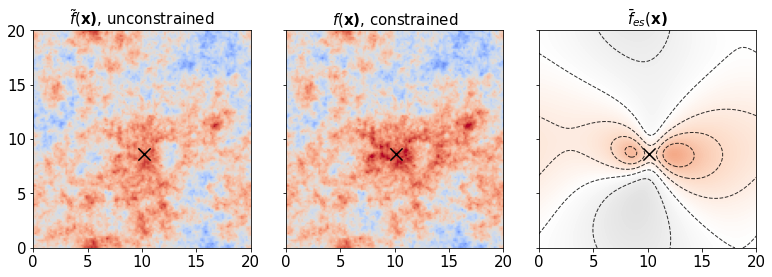

In [17]:
f, axes = plt.subplots(1,3,sharex=True,sharey = True,figsize=[13,4])
f.subplots_adjust(hspace=0.15,wspace=0.15)
cms = ['coolwarm','coolwarm','RdGy_r']
titles = [r'$\tilde{f}(\bf{x})$, unconstrained',r'$f(\bf{x})$, constrained',r'$\bar{f}_{es} (\bf x)$']
for i,dx in enumerate([dx_field,dx_constraint,dx_ensemble]):
    ax = axes.flat[i]
    projection = np.transpose(np.mean(dx[:,:,70:102],axis=-1))
    ax.imshow(projection,cmap=cms[i],origin='lower',vmin=-10,vmax=10,extent=(0,Lbox,0,Lbox))
    ax.scatter(xpk[0],xpk[1],s=150,marker='x',c='black')
    ax.set_title(titles[i],fontsize=15)
    if i==2:
        ax.contour(projection,colors='black',alpha=0.8,linewidths=1,linestyles='dashed',levels=5,extent=(0,Lbox,0,Lbox))

Now we evolve unconstrained, constrained density fields with a non-linear model, projected on xy plane with slab width of 5 Mpc/h.


This may take about 1 minute -- but look, the largest halo has shifted to the peak of the constraint!

In [18]:
Q = solver.pm.generate_uniform_particle_grid(shift=0.5)

den_field_lin = solver.pm.create('real', value=dx_field)
S = solver.lpt(den_field_lin.r2c(), Q, 0.1, order=2)
S = solver.nbody(S, leapfrog(np.linspace(0.1, 1.0, 10)))
dx_field_nl = solver.pm.paint(S.X)

den_field_lin = solver.pm.create('real', value=dx_constraint)
S = solver.lpt(den_field_lin.r2c(), Q, 0.1, order=2)
S = solver.nbody(S, leapfrog(np.linspace(0.1, 1.0, 10)))
dx_constraint_nl = solver.pm.paint(S.X)

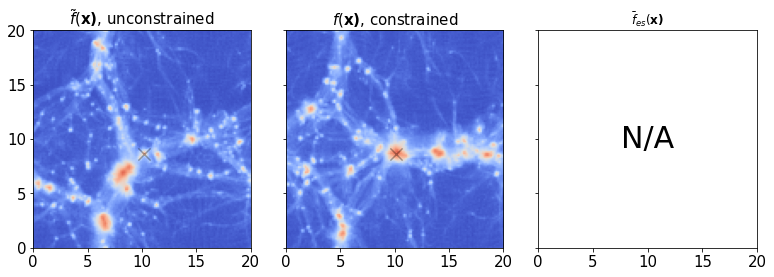

In [19]:
f, axes = plt.subplots(1,3,sharex=True,sharey = True,figsize=[13,4])
f.subplots_adjust(hspace=0.15,wspace=0.15)
Q = solver.pm.generate_uniform_particle_grid(shift=0.5)

ax = axes.flat[2]
ax.set_title(titles[2])
ax.text(0.5, 0.5, 'N/A', fontsize=30, ha='center', va='center', transform=ax.transAxes)

for i,dx_nl in enumerate([dx_field_nl,dx_constraint_nl]):
    ax = axes.flat[i]
    projection = np.log(1 + np.transpose(np.mean(dx_nl[:,:,70:102],axis=-1)))
    ax.imshow(projection,cmap=cms[i],origin='lower', vmin=0, vmax=6, extent=(0,Lbox,0,Lbox))
    ax.scatter(xpk[0],xpk[1],s=150,marker='x',c='black', alpha=0.3)
    ax.set_title(titles[i],fontsize=15)
